# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: Иванов Александр Вадимович

Группа:  MADE-DS-12

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

In [1]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import random
import folium
import datetime
from folium import plugins

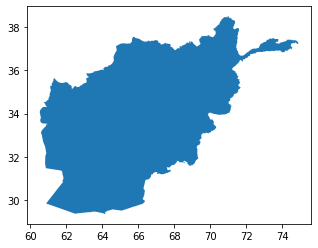

In [2]:
afghanistan = gpd.read_file('https://nominatim.openstreetmap.org/search?country=Afghanistan&polygon_geojson=1&format=geojson')

# проверим данные
afghanistan.plot()

In [3]:
def random_point():
    x = random.uniform(-180, 180)
    y = random.uniform(-90, 90)
    return x, y

points = []
point = random_point()
while not Point(point).within(afghanistan.geometry.iloc[0]):
    points.append(point)
    point = random_point()
points.append(point)

In [4]:
def plot(points):
    m = folium.Map(
        tiles='cartodbpositron',
        min_zoom=2,
    )
    features = [
        {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': point,
            },
            'properties': {
                'time': str(datetime.datetime.now() + datetime.timedelta(seconds=time * 60))[:19].replace(' ', 'T'),
                'id': 'point',
                'icon': 'circle',
                'iconstyle': {
                    'fillColor': 'red',
                    'fillOpacity': 0.6,
                    'stroke': 'false',
                    'radius': 7
                },
                'style': {'weight': 0},
            }
        } for point, time in zip(points, range(len(points)))
    ]

    features[-1]['properties']['iconstyle']['fillColor'] = 'green'

    plugins.TimestampedGeoJson(
        {
            'type': 'FeatureCollection',
            'features': features
        },
        period='PT1M',
        add_last_point=True,
        auto_play=True,
        loop=False,
        max_speed=40,
        loop_button=True,
        time_slider_drag_update=True,
    ).add_to(m)
    
    return m

In [5]:
plot(points)

Гифка, так как folium не отображается на гитхабе

![Alt Text](random_points.gif)

### С учётом расстояния

Из следующих предпосылок можно ускорить поиск:
- 1 градус около 100 км, а размеры афганистана явно больше,
- Афганистан в северном полушарии,
- Афганистан не в океане.

Ну а если без априорной информации, то можно искать с разным шагом. Размер шага будет зависеть от расстояние до Афганистана.

In [6]:
points = [random_point(), ]
while not Point(point).within(afghanistan.geometry.iloc[0]):
    distance = Point(points[-1]).distance(afghanistan.geometry.iloc[0])
    point = (
        random.choice([x for x in np.arange(
            min((point[0] - distance) % 180, (point[0] + distance) % 180),
            max((point[0] - distance) % 180, (point[0] + distance) % 180),
            distance / 2
        )]),
        random.choice([y for y in np.arange(
            min((point[1] - distance) % 180, (point[1] + distance) % 180),
            max((point[1] - distance) % 180, (point[1] + distance) % 180),
            distance / 2
        )])
    )
    points.append(point)
points.append(point)

In [7]:
plot(points)

Скорость разная, гифка с полным рандомом ускорен в 4 раза, по сравнению с этой гифкой.

![Alt Text](not_naive_random.gif)

In [8]:
print('Найденная точка', point)

Найденная точка (62.30209494551522, 32.21161514950968)


## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [60]:
import pycountry # https://wiki.openstreetmap.org/wiki/Nominatim/Country_Codes ипользуется ISO 3166
from OSMPythonTools.nominatim import Nominatim
import time
from collections import OrderedDict
from OSMPythonTools.data import Data
from OSMPythonTools.overpass import overpassQueryBuilder
from OSMPythonTools.overpass import Overpass
import geopy.distance


countries = list(pycountry.countries)

countries_info = {}
nominatim = Nominatim()

for country in countries:
    areaId = nominatim.query(country.alpha_2).areaId()
    if areaId is not None:
        countries_info[country.alpha_2] = {'areaId': areaId, 'name': country.name}

In [61]:
dimensions = OrderedDict([('country', OrderedDict({x: countries_info[x]['areaId'] for x in countries_info})),])

In [62]:
overpass = Overpass()

### Страна с наибольшим количеством объектов недвижимости

In [63]:
def fetch(country):
    query = overpassQueryBuilder(
        area=country, 
        elementType=['node', 'way', 'relation'], 
        selector=['"building"="residential"', '"building"="house"'],
        out='count',)
    return overpass.query(query, timeout=20).countElements()
data = Data(fetch, dimensions)

In [64]:
data.toColumn().sort_values(ascending=False).head()

country
BI    1304883
BE    1304883
PH    1277490
CZ    1058268
UA     926088
Name: value, dtype: int64

In [65]:
country_with_max_num_bildings = countries_info[data.toColumn().idxmax()]
country_with_max_num_bildings['code'] = data.toColumn().idxmax()
print(country_with_max_num_bildings)

{'areaId': 3600052411, 'name': 'Burundi', 'code': 'BI'}


In [66]:
query = overpassQueryBuilder(
    area=country_with_max_num_bildings['areaId'], 
    elementType=['node'], 
    selector=['"amenity"="atm"'],)
atms = overpass.query(query)
coords = [(node.lon(), node.lat()) for node in atms.nodes()]

In [67]:
from rtree import index
idx = index.Index()

for i, coord in enumerate(coords):
    idx.insert(i, coord)

In [68]:
nearest_atms = [coords[i] for i in idx.nearest((34.37, 26.73), 5)]

In [69]:
from geopy.distance import geodesic
for i, atm_point in enumerate(nearest_atms):
    print(f'Расстояние до банкомата {i}, км.', geodesic(atm_point, point).kilometers)

Расстояние до банкомата 0, км. 6430.074026577649
Расстояние до банкомата 1, км. 6430.365879016567
Расстояние до банкомата 2, км. 6430.447392788469
Расстояние до банкомата 3, км. 6439.846180716672
Расстояние до банкомата 4, км. 6431.394840870932


### Страна с наибольшим количеством аптек в столице

In [101]:
from countryinfo import CountryInfo

# del countries_info['AX']
for country in countries_info:
    try:
        countries_info[country]['cap'] = CountryInfo(country).capital()
    except:
        pass

In [102]:
ctd = []
for country in countries_info:
    try:
        areaId = nominatim.query(countries_info[country]['cap']).areaId()
        if areaId is not None:
            countries_info[country]['cap_areaId'] = areaId
        else:
            ctd.append(country)
    except:
        pass

[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[

In [124]:
dimensions = OrderedDict([('cap', OrderedDict({x: countries_info[x]['cap_areaId'] for x in [x for x in countries_info.keys() if countries_info[x].get('cap_areaId', 0) > 0 and countries_info[x].get('cap_areaId', 0) not in [3600059470]]})),])

In [119]:
overpass = Overpass()

In [125]:
def fetch(cap):
    query = overpassQueryBuilder(
        area=cap, 
        elementType=['node', 'way', 'relation'], 
        selector=['"amenity"="pharmacy"'],
        out='count',)
    return overpass.query(query, timeout=200).countElements()
data = Data(fetch, dimensions)

[overpass] downloading data: [timeout:200][out:json];area(3607751694)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);way["amenity"="pharmacy"](area.searchArea);relation["amenity"="pharmacy"](area.searchArea);); out count;
[overpass] downloading data: [timeout:200][out:json];area(3608748136)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);way["amenity"="pharmacy"](area.searchArea);relation["amenity"="pharmacy"](area.searchArea);); out count;
[overpass] downloading data: [timeout:200][out:json];area(3609330372)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);way["amenity"="pharmacy"](area.searchArea);relation["amenity"="pharmacy"](area.searchArea);); out count;
[overpass] downloading data: [timeout:200][out:json];area(3607322726)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);way["amenity"="pharmacy"](area.searchArea);relation["amenity"="pharmacy"](area.searchArea);); out count;
[overpass] downloading data: [timeout:200][out:json];area(3604136816

In [126]:
data.toColumn().sort_values(ascending=False).head()

cap
DZ    3246
JP    2407
ES    1800
CO    1242
UA    1085
Name: value, dtype: int64

In [127]:
country_with_max_num_pharmacy = countries_info[data.toColumn().idxmax()]
country_with_max_num_pharmacy['code'] = data.toColumn().idxmax()
print(country_with_max_num_pharmacy)

{'areaId': 3600192756, 'name': 'Algeria', 'cap': 'Algiers', 'cap_areaId': 3600192756, 'code': 'DZ'}


In [131]:
query = overpassQueryBuilder(
    area=country_with_max_num_pharmacy['areaId'], 
    elementType=['node'], 
    selector=['"amenity"="school"'],)
schools = overpass.query(query)
coords = [(node.lon(), node.lat()) for node in atms.nodes()]

In [132]:
from rtree import index
idx = index.Index()

for i, coord in enumerate(coords):
    idx.insert(i, coord)
    
nearest_schools = [coords[i] for i in idx.nearest((34.37, 26.73), 5)]

from geopy.distance import geodesic
for i, school_point in enumerate(nearest_schools):
    print(f'Расстояние до школы {i}, км.', geodesic(school_point, point).kilometers)

Расстояние до школы 0, км. 5859.588141493146
Расстояние до школы 1, км. 5859.65293371473
Расстояние до школы 2, км. 5859.8485229135895
Расстояние до школы 3, км. 5860.278071149704
Расстояние до школы 4, км. 5871.249947140925


Страна с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [ ]:
# put your code here